<a href="https://colab.research.google.com/github/rekhasahoo/NOISE_AUTO_TUNING/blob/main/Noise_Aware_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets


Dataset Visualization

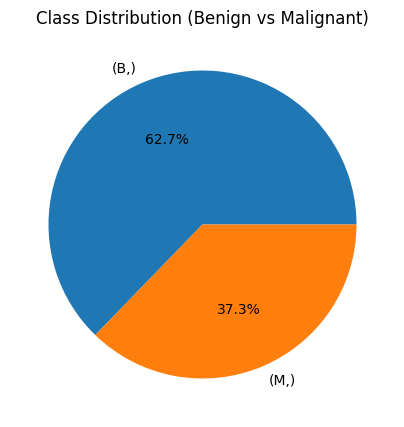

In [ ]:
plt.figure(figsize=(5,5))
y.value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Class Distribution (Benign vs Malignant)")
plt.ylabel("")
plt.show()


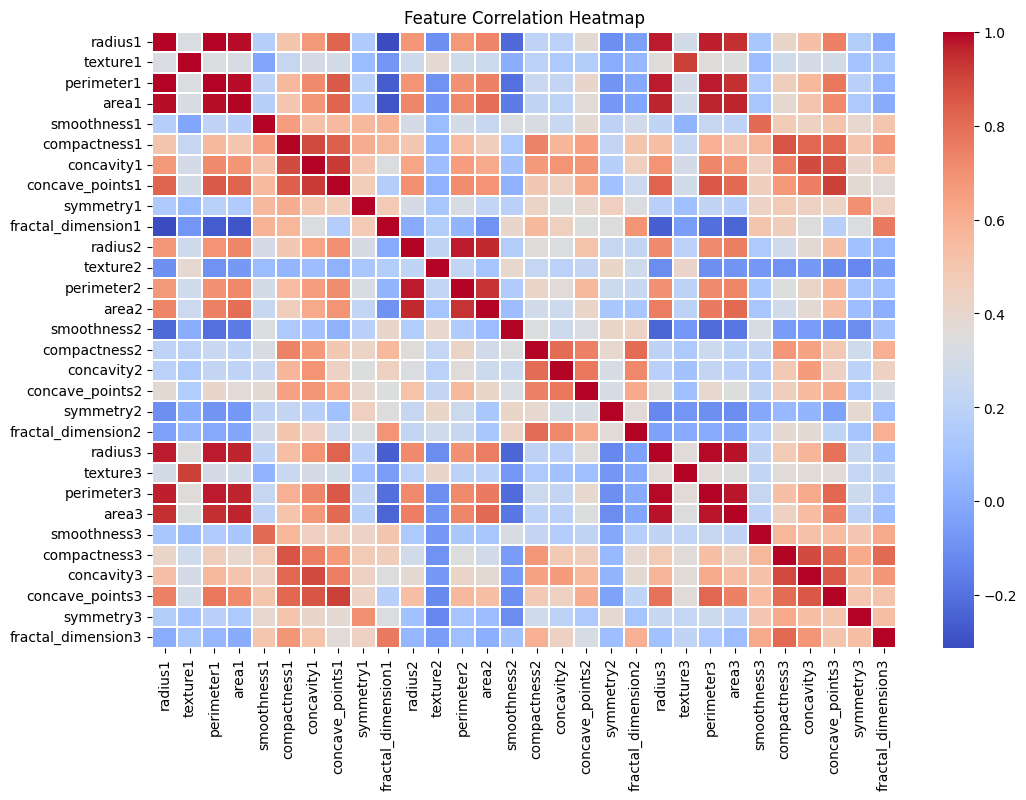

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), cmap='coolwarm', linewidths=0.2)
plt.title("Feature Correlation Heatmap")
plt.show()


Preprocessing

In [ ]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel())

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, 30)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


Inject Controlled Label Noise

In [ ]:
def inject_label_noise(labels, noise_ratio=0.4):
    noisy_labels = labels.clone()
    n_noisy = int(noise_ratio * len(labels))
    idx = torch.randperm(len(labels))[:n_noisy]

    noisy_labels[idx] = 1 - noisy_labels[idx]  # binary flip
    return noisy_labels

y_train_noisy = inject_label_noise(y_train, noise_ratio=0.4)


BASE CNN MODEL (USED BY BOTH)

In [ ]:
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(1, 16, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16 * 28, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


Baseline CNN Training

In [ ]:
def train_baseline(model, X, y, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

    return model


Noise-Aware Training (CORE NOVELTY)

In [ ]:
def compute_reliability(outputs):
    probs = torch.softmax(outputs, dim=1)
    confidence, _ = torch.max(probs, dim=1)
    return confidence.detach()


In [ ]:
def train_noise_aware(model, X, y, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(reduction='none')

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        losses = criterion(outputs, y)
        reliability = compute_reliability(outputs)
        weighted_loss = (reliability * losses).mean()
        weighted_loss.backward()
        optimizer.step()

    return model


Train Both Models

In [ ]:
baseline_model = CNN1D()
noise_aware_model = CNN1D()

baseline_model = train_baseline(baseline_model, X_train, y_train_noisy)
noise_aware_model = train_noise_aware(noise_aware_model, X_train, y_train_noisy)


Evaluation & Comparison Metrics

In [ ]:
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1).numpy()
    return {
        "Accuracy": accuracy_score(y, preds),
        "Precision": precision_score(y, preds),
        "Recall": recall_score(y, preds),
        "F1": f1_score(y, preds),
        "CM": confusion_matrix(y, preds)
    }


In [ ]:
baseline_results = evaluate(baseline_model, X_test, y_test.numpy())
noise_aware_results = evaluate(noise_aware_model, X_test, y_test.numpy())

print("Baseline:", baseline_results)
print("Noise-Aware:", noise_aware_results)


Baseline: {'Accuracy': 0.7631578947368421, 'Precision': 0.6119402985074627, 'Recall': 0.9761904761904762, 'F1': 0.7522935779816514, 'CM': array([[46, 26],
       [ 1, 41]])}
Noise-Aware: {'Accuracy': 0.6929824561403509, 'Precision': 0.5573770491803278, 'Recall': 0.8095238095238095, 'F1': 0.6601941747572816, 'CM': array([[45, 27],
       [ 8, 34]])}
